# Xarray for multidimensional labeled data

The original version of this Notebook is here: https://github.com/pangeo-data/pangeo-tutorial-agu-2018

Xarray is designed to make it easier to work with with _labeled multidimensional data_. By _multidimensional data_ (also often called _N-dimensional_), we mean data with many independent dimensions or axes. For example, we might represent Earth's surface temperature $T$ as a three dimensional variable

$$ T(x, y, t) $$

where $x$ and $y$ are spatial dimensions and and $t$ is time. By _labeled_, we mean data that has metadata associated with it describing the names and relationships between the variables. The cartoon below shows a "data cube" schematic dataset with temperature and preciptation sharing the same three dimensions, plus longitude and latitude as auxilliary coordinates.

![xarray data model](https://github.com/pydata/xarray/raw/master/doc/_static/dataset-diagram.png)

## Getting Help with Xarray

Here are some important resources for learning more about xarray and getting help.

- [Xarray Documentation](http://xarray.pydata.org/en/latest/)
- [Xarray GitHub Issue Tracker](https://github.com/pydata/xarray/issues)
- [Xarray questions on StackOverflow](https://stackoverflow.com/questions/tagged/python-xarray)

## Learning Goals for Xarray

#### Dataset Creation

1. Describe the core xarray data structures, the `DataArray` and the `Dataset`, and the components that make them up, including: Data Variables, Dimensions, Coordinates, Indexes, and Attributes
1. Create xarray `DataArray`s out of raw numpy arrays
1. Create xarray objects with and without indexes
1. Load xarray datasets from netCDF files
1. View and set attributes 

#### Indexing

1. Select data by position using `.isel` with values or slices
1. Select data by label using `.sel` with values or slices
1. Select timeseries data by date/time with values or slices
1. Use nearest-neighbor lookups with `.sel`

#### Computation

1. Do basic arithmetic with DataArrays and Datasets
1. Use numpy universal function on DataArrays and Datasets, or use corresponding built-in xarray methods
1. Combine multiple xarray objects in arithmetic operations and understand how they are broadcasted / aligned
1. Perform aggregation (reduction) along one or multiple dimensions of a DataArray or Dataset

#### Plotting

1. Use built-in xarray plotting for 1D and 2D DataArrays
1. Customize plots with options
1. Use cartopy together with xarray to create maps


## I. Xarray data structures

Like Pandas, xarray has two fundamental data structures:
* a `DataArray`, which holds a single multi-dimensional variable and its coordinates
* a `Dataset`, which holds multiple variables that potentially share the same coordinates

### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

Let's start by constructing some DataArrays manually 

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

Here we model the simple function

$$f(x) = sin(x)$$

on the interval $-\pi$ to $\pi$. We start by creating the data as numpy arrays.

In [2]:
x = np.linspace(-np.pi, np.pi, 19)
f = np.sin(x)

Now we are going to put this into an xarray DataArray.

A simple DataArray without dimensions or coordinates isn't much use.

In [3]:
da_f = xr.DataArray(f)
da_f

<xarray.DataArray (dim_0: 19)>
array([-1.224647e-16, -3.420201e-01, -6.427876e-01, -8.660254e-01,
       -9.848078e-01, -9.848078e-01, -8.660254e-01, -6.427876e-01,
       -3.420201e-01,  0.000000e+00,  3.420201e-01,  6.427876e-01,
        8.660254e-01,  9.848078e-01,  9.848078e-01,  8.660254e-01,
        6.427876e-01,  3.420201e-01,  1.224647e-16])
Dimensions without coordinates: dim_0

We can add a dimension name...

In [4]:
da_f = xr.DataArray(f, dims=['x'])
da_f

<xarray.DataArray (x: 19)>
array([-1.224647e-16, -3.420201e-01, -6.427876e-01, -8.660254e-01,
       -9.848078e-01, -9.848078e-01, -8.660254e-01, -6.427876e-01,
       -3.420201e-01,  0.000000e+00,  3.420201e-01,  6.427876e-01,
        8.660254e-01,  9.848078e-01,  9.848078e-01,  8.660254e-01,
        6.427876e-01,  3.420201e-01,  1.224647e-16])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [5]:
da_f = xr.DataArray(f, dims=['x'], coords={'x': x})
da_f

<xarray.DataArray (x: 19)>
array([-1.224647e-16, -3.420201e-01, -6.427876e-01, -8.660254e-01,
       -9.848078e-01, -9.848078e-01, -8.660254e-01, -6.427876e-01,
       -3.420201e-01,  0.000000e+00,  3.420201e-01,  6.427876e-01,
        8.660254e-01,  9.848078e-01,  9.848078e-01,  8.660254e-01,
        6.427876e-01,  3.420201e-01,  1.224647e-16])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

Xarray has built-in plotting, like pandas.

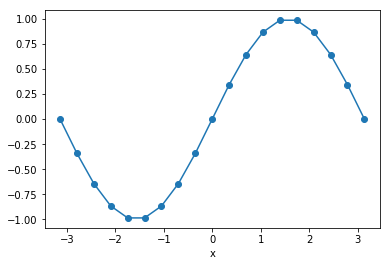

In [6]:
da_f.plot(marker='o')

### Selecting Data

We can always use regular numpy indexing and slicing on DataArrays to get the data back out.

In [7]:
# get the 10th item
da_f[10]

<xarray.DataArray ()>
array(0.34202)
Coordinates:
    x        float64 0.3491

In [8]:
# git the first 10 items
da_f[:10]

<xarray.DataArray (x: 10)>
array([-1.224647e-16, -3.420201e-01, -6.427876e-01, -8.660254e-01,
       -9.848078e-01, -9.848078e-01, -8.660254e-01, -6.427876e-01,
       -3.420201e-01,  0.000000e+00])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... -0.6981 -0.3491 0.0

However, it is often much more powerful to use xarray's `.sel()` method to use label-based indexing. This allows us to fetch values based on the value of the coordinate, not the numerical index.

In [9]:
da_f.sel(x=0)

<xarray.DataArray ()>
array(0.)
Coordinates:
    x        float64 0.0

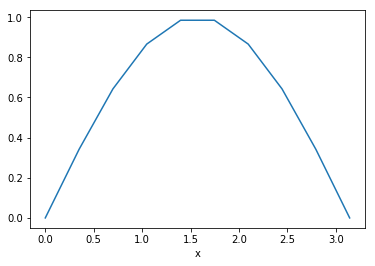

In [10]:
da_f.sel(x=slice(0, np.pi)).plot()

### Basic Computations

When we perform mathematical manipulations of xarray DataArrays, the coordinates come along for the ride.
Imagine we want to calcuate

$$ g = f^2 + 1 $$

We can apply familiar numpy operations to xarray objects.


In [11]:
da_g = da_f**2 + 1
da_g

<xarray.DataArray (x: 19)>
array([1.      , 1.116978, 1.413176, 1.75    , 1.969846, 1.969846, 1.75    ,
       1.413176, 1.116978, 1.      , 1.116978, 1.413176, 1.75    , 1.969846,
       1.969846, 1.75    , 1.413176, 1.116978, 1.      ])
Coordinates:
  * x        (x) float64 -3.142 -2.793 -2.443 -2.094 ... 2.094 2.443 2.793 3.142

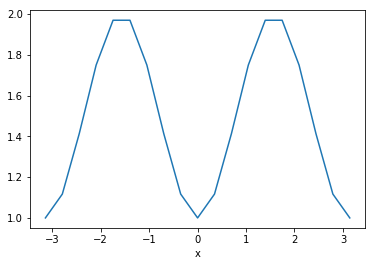

In [12]:
da_g.plot()

### Exercise

- Multipy the DataArrays `da_f` and `da_g` together.
- Select the range $-1 < x < 1$
- Plot the result

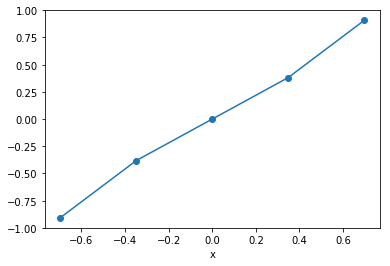

In [13]:
(da_f * da_g).sel(x=slice(-1, 1)).plot(marker='o')

## II. Multidimensional Data

If we are just dealing with 1D data, Pandas and Xarray have very similar capabilities. Xarray's real potential comes with multidimensional data.

At this point we will load data from a netCDF file into an xarray dataset.


In [14]:
import intake
catalog_url = 'https://raw.githubusercontent.com/obidam/m2poc2019/master/m2poc_data_catalog.yml'
cat = intake.Catalog(catalog_url)
ds = cat.isas15_temp_natl.read_chunked()
print(ds)

<xarray.Dataset>
Dimensions:    (depth: 152, latitude: 67, longitude: 91, time: 168)
Coordinates:
  * depth      (depth) float32 1.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
  * latitude   (latitude) float32 25.151031 25.602783 ... 50.3791 50.696884
  * longitude  (longitude) float32 285.0 285.5 286.0 286.5 ... 329.0 329.5 330.0
  * time       (time) datetime64[ns] 2002-01-15 2002-02-15 ... 2015-12-15
Data variables:
    temp       (time, depth, latitude, longitude) float32 dask.array<shape=(168, 152, 67, 91), chunksize=(42, 38, 17, 23)>


### Datasets

We just created our first xarray `Dataset`. What is a dataset? A Dataset is simply an object wihich holds many DataArrays which potentially can share coordinates.

Datasets have three main elements:
- Data variables
- Coordiantes (which provide labels and other ancillary information about the data variables)
- Attributes (additional metadata for the dataset)

This dataset only contains one variable (`temp`), which we can access in the following two ways

In [15]:
# both do the exact same thing

# dictionary syntax
temp = ds['temp']

# attribute syntax
temp = ds.temp

temp

<xarray.DataArray 'temp' (time: 168, depth: 152, latitude: 67, longitude: 91)>
dask.array<shape=(168, 152, 67, 91), dtype=float32, chunksize=(42, 38, 17, 23)>
Coordinates:
  * depth      (depth) float32 1.0 3.0 5.0 10.0 ... 1940.0 1960.0 1980.0 2000.0
  * latitude   (latitude) float32 25.151031 25.602783 ... 50.3791 50.696884
  * longitude  (longitude) float32 285.0 285.5 286.0 286.5 ... 329.0 329.5 330.0
  * time       (time) datetime64[ns] 2002-01-15 2002-02-15 ... 2015-12-15
Attributes:
    long_name:      Temperature 
    standard_name:  sea_water_temperature
    units:          degree_Celsius
    valid_max:      20000
    valid_min:      -23000

### Multidimensional Indexing

In this example, we take advantage of the fact that xarray understands time to select a particular date

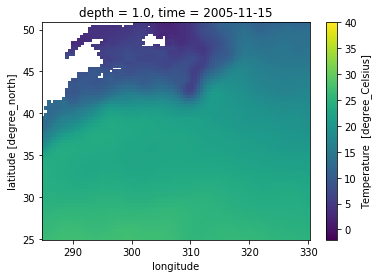

In [16]:
temp.sel(time='2005-11-01', method='nearest').sel(depth=0, method='nearest').plot(vmin=-2, vmax=40)

But we can select along any axis

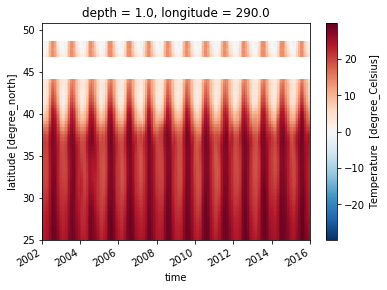

In [17]:
temp.sel(longitude=290, method='nearest').sel(depth=0, method='nearest').transpose().plot()

And create new variables:

In [18]:
sst = temp.sel(depth=0, method='nearest')
sst

<xarray.DataArray 'temp' (time: 168, latitude: 67, longitude: 91)>
dask.array<shape=(168, 67, 91), dtype=float32, chunksize=(42, 17, 23)>
Coordinates:
    depth      float32 1.0
  * latitude   (latitude) float32 25.151031 25.602783 ... 50.3791 50.696884
  * longitude  (longitude) float32 285.0 285.5 286.0 286.5 ... 329.0 329.5 330.0
  * time       (time) datetime64[ns] 2002-01-15 2002-02-15 ... 2015-12-15
Attributes:
    long_name:      Temperature 
    standard_name:  sea_water_temperature
    units:          degree_Celsius
    valid_max:      20000
    valid_min:      -23000

### Label-Based Reduction Operations

Usually the process of data analysis involves going from a big, multidimensional dataset to a few concise figures.
Inevitably, the data must be "reduced" somehow. Examples of simple reduction operations include:

- Mean
- Standard Deviation
- Minimum
- Maximum

etc. Xarray supports all of these and more, via a familiar numpy-like syntax. But with xarray, you can specify the reductions by dimension.

First we start with the default, reduction over all dimensions:

In [19]:
sst.mean()

<xarray.DataArray 'temp' ()>
dask.array<shape=(), dtype=float32, chunksize=()>
Coordinates:
    depth    float32 1.0

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


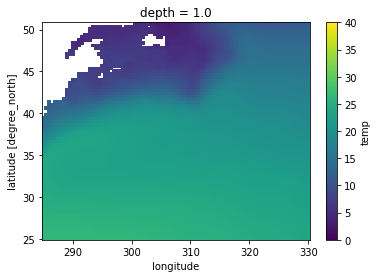

In [20]:
sst_time_mean = sst.mean(dim='time')
sst_time_mean.plot(vmin=0, vmax=40)

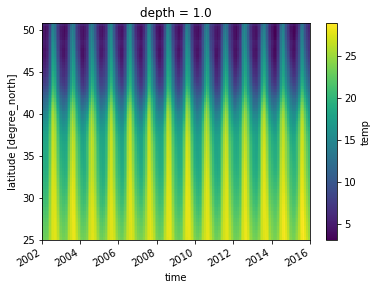

In [21]:
sst_zonal_mean = sst.mean(dim='longitude')
sst_zonal_mean.transpose().plot()

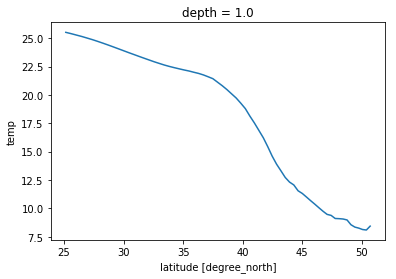

In [22]:
sst_time_and_zonal_mean = sst.mean(dim=('time', 'longitude'))
sst_time_and_zonal_mean.plot()

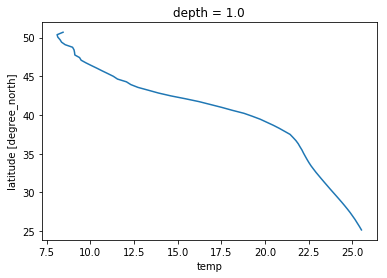

In [23]:
# some might prefer to have lat on the y axis
sst_time_and_zonal_mean.plot(y='latitude')

### More Complicated Example: Weighted Mean

The means we calculated above were "naive"; they were straightforward numerical means over the different dimensions of the dataset. They did not account, for example, for spherical geometry of the globe and the necessary weighting factors. Although xarray is very useful for geospatial analysis, **it has no built-in understanding of geography**.

Below we show how to create a proper weighted mean by using the formula for the area element in spherical coordinates. This is a good illustration of several xarray concepts.

The [area element for lat-lon coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates) is

$$ \delta A = R^2 \delta \phi \delta \lambda \cos(\phi) $$

where $\phi$ is latitude, $\delta \phi$ is the spacing of the points in latitude, $\delta \lambda$ is the spacing of the points in longitude, and $R$ is Earth's radius. (In this formula, $\phi$ and $\lambda$ are measured in radians.) Let's use xarray to create the weight factor.

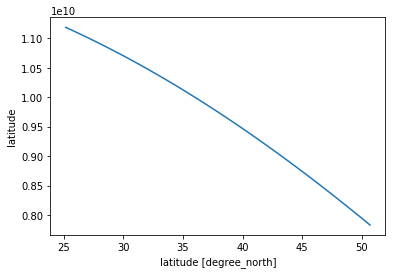

In [24]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.latitude))
dA.plot()

In [25]:
dA.where(sst[0].notnull())

<xarray.DataArray (latitude: 67, longitude: 91)>
dask.array<shape=(67, 91), dtype=float32, chunksize=(17, 23)>
Coordinates:
  * latitude   (latitude) float32 25.151031 25.602783 ... 50.3791 50.696884
    depth      float32 1.0
  * longitude  (longitude) float32 285.0 285.5 286.0 286.5 ... 329.0 329.5 330.0
    time       datetime64[ns] 2002-01-15

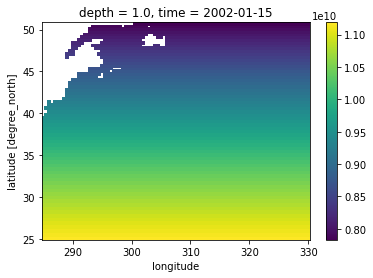

In [26]:
pixel_area = dA.where(sst[0].notnull())
pixel_area.plot()

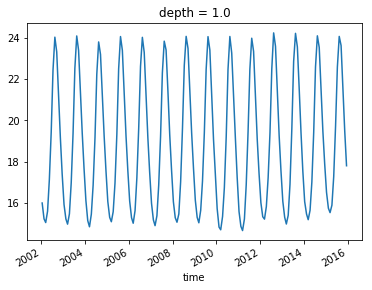

In [27]:
total_ocean_area = pixel_area.sum(dim=('longitude', 'latitude'))
sst_weighted_mean = (sst * pixel_area).sum(dim=('longitude', 'latitude')) / total_ocean_area
sst_weighted_mean.plot()

### Exercise

Find the maximum temperature in a box spanning the coordinates

- lon: 60W - 40W
- lat: 20N - 40N

### Maps

Xarray integrates with cartopy to enable you to plot your data on a map

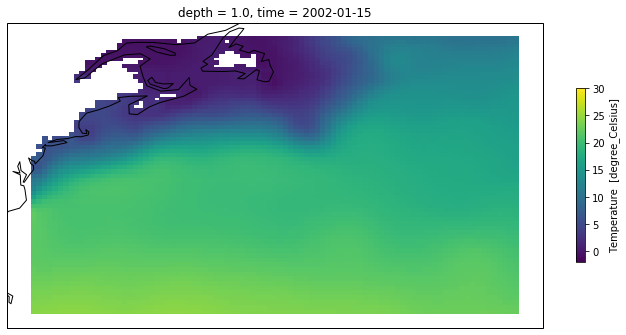

In [28]:
import cartopy.crs as ccrs

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

sst[0].plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=30,
            cbar_kwargs={'shrink': 0.4})

### Exercise

Repeat the above with a [projection of your choice](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html)

## IV. Opening Many Files

One of the killer features of xarray is its ability to open many files into a single dataset. We do this with the `open_mfdataset` function.

In [29]:
ds_all = xr.open_mfdataset('../../../data/aviso/*.nc')
ds_all

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 31)
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2018-12-01 2018-12-02 ... 2018-12-31
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(31, 720, 2), chunksize=(1, 720, 2)>
    lon_bnds   (time, longitude, nv) float32 dask.array<shape=(31, 1440, 2), chunksize=(1, 1440, 2)>
    ugosa      (time, latitude, longitude) float64 dask.array<shape=(31, 720, 1440), chunksize=(1, 720, 1440)>
    adt        (time, latitude, longitude) float64 dask.array<shape=(31, 720, 1440), chunksize=(1, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(31, 720, 1440), chunksize=(1, 720, 1440)>
    sla        (

Now we have 1 month of daily SSH from 31 files !